In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('seaborn-pastel')
import pandas as pd   # Works for pandas > v0.20
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
df = pd.read_csv("data/SampleSuperstore.csv")
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

# Univariate time series 
furniture_sales = furniture[['Order Date','Sales']]

# As read in as csv convert to date to datetime and make as the index
furniture_sales.sort_values('Order Date')
furniture_sales['Order Date'] = pd.to_datetime(furniture_sales['Order Date'])

# Sum the sales by date
furniture_sales = furniture_sales.groupby('Order Date')['Sales'].sum().reset_index()
furniture_sales = furniture_sales.set_index('Order Date')

# Create a monthly summary for EDA
furniture_sales_to_monthly = furniture_sales['Sales'].resample('MS').sum()

# Create a weekly set for predictions
furniture_sales_weekly = pd.DataFrame(furniture_sales['Sales'].resample('W').sum())

In [5]:
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,08/11/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,08/11/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,11/10/2015,18/10/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,09/06/2014,14/06/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,09/06/2014,14/06/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


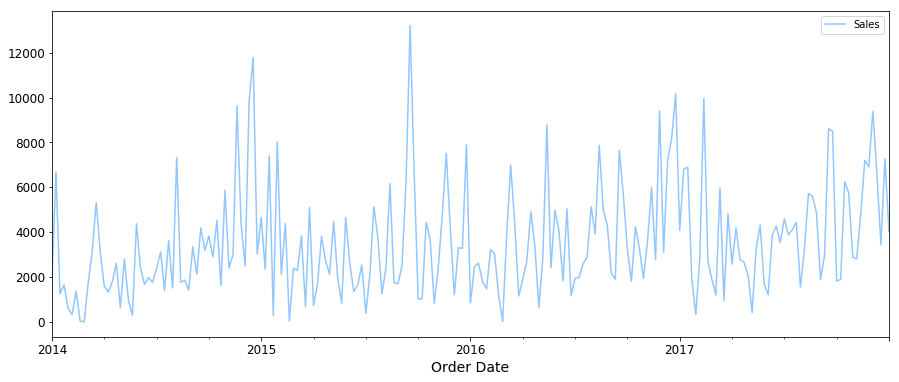

In [7]:
furniture_sales_weekly.plot(figsize = (15,6))
plt.savefig('Sales_Data.png')
plt.show()

In [15]:
current = furniture_sales_weekly['Sales']
furniture_sales_weekly['prev_Sales'] = furniture_sales_weekly['Sales'].shift(1)

furniture_sales_weekly.corr()

,Sales,prev_Sales
Sales,1.000000,0.209892
prev_Sales,0.209892,1.000000


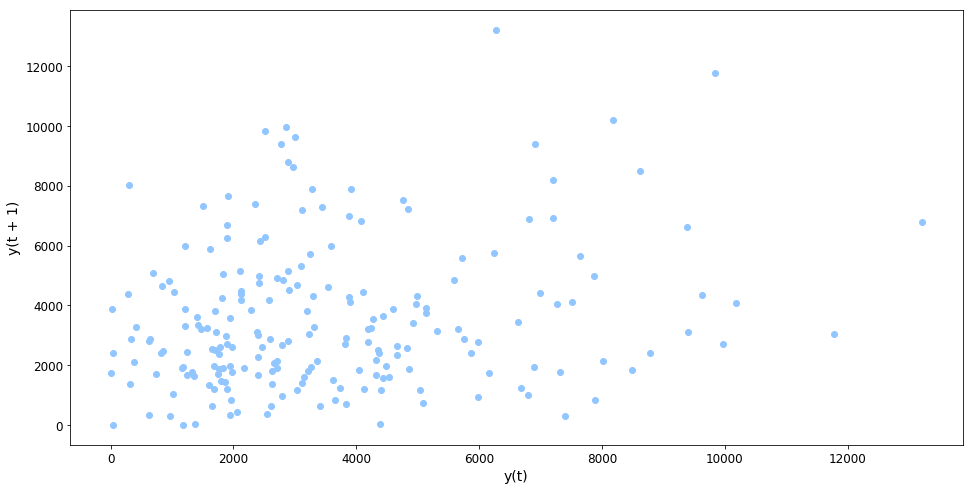

In [12]:
# Look at the correlation of one time shift
matplotlib.rcParams['figure.figsize'] = 16, 8
pd.plotting.lag_plot(furniture_sales_weekly['Sales'] )
plt.savefig('images/Timestep1correlation.png')
plt.show()


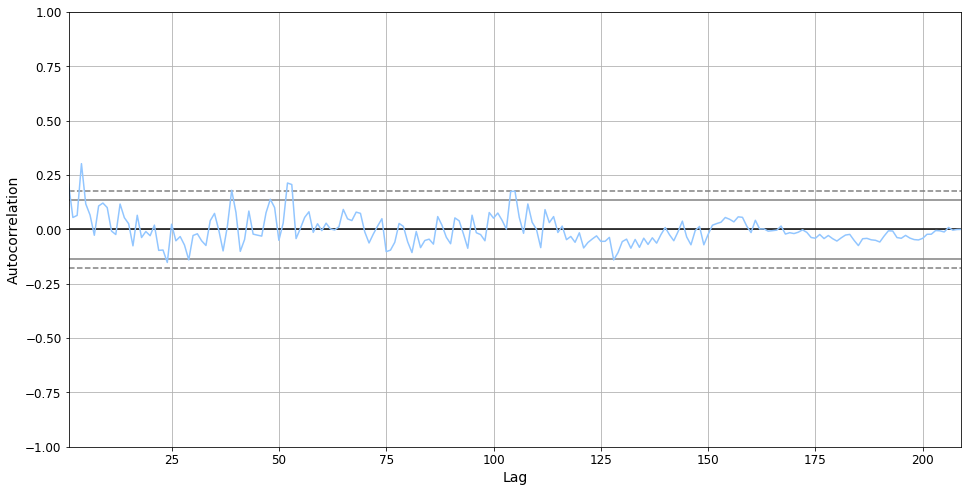

In [22]:
pd.plotting.autocorrelation_plot(furniture_sales_weekly['Sales'])
plt.savefig('images/pandas_acf.png')
plt.show()

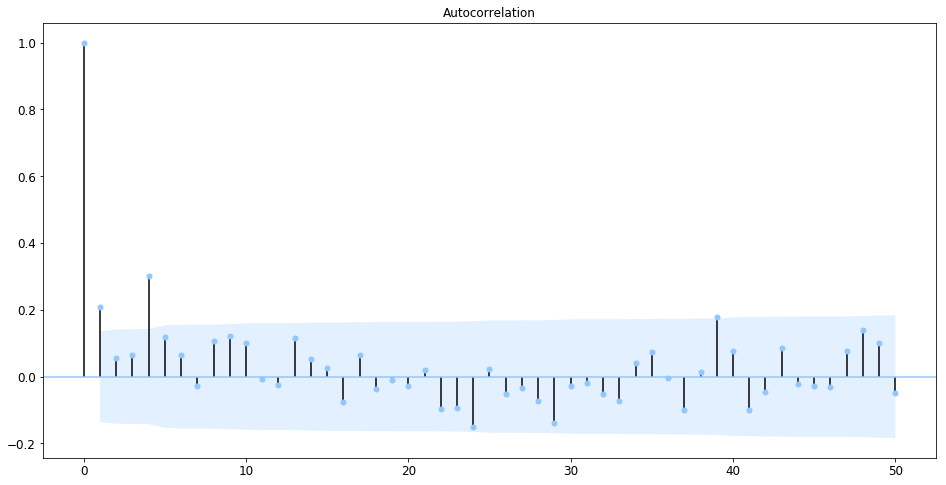

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(furniture_sales_weekly['Sales'], lags = 50)
plt.savefig('images/statsmodels_acf.png')
plt.show()

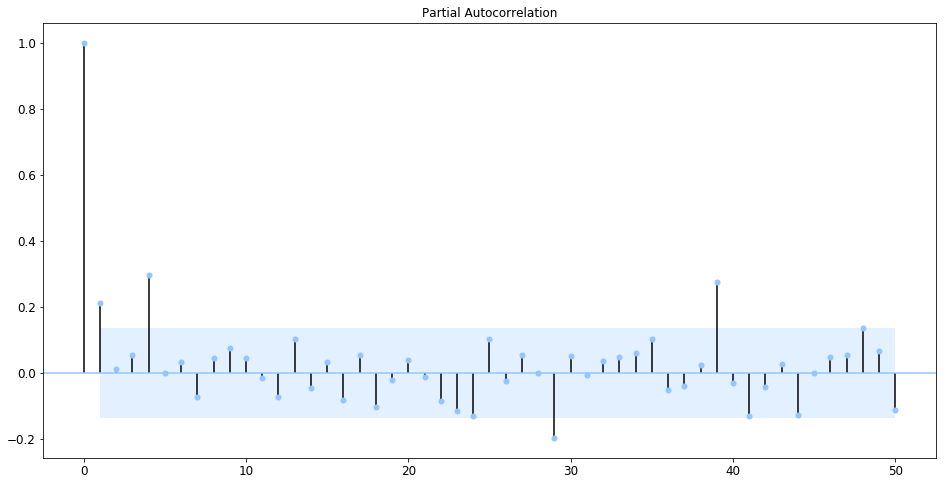

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(furniture_sales_weekly['Sales'], lags =50)
plt.savefig('images/statsmodels_pacf.png')
plt.show()

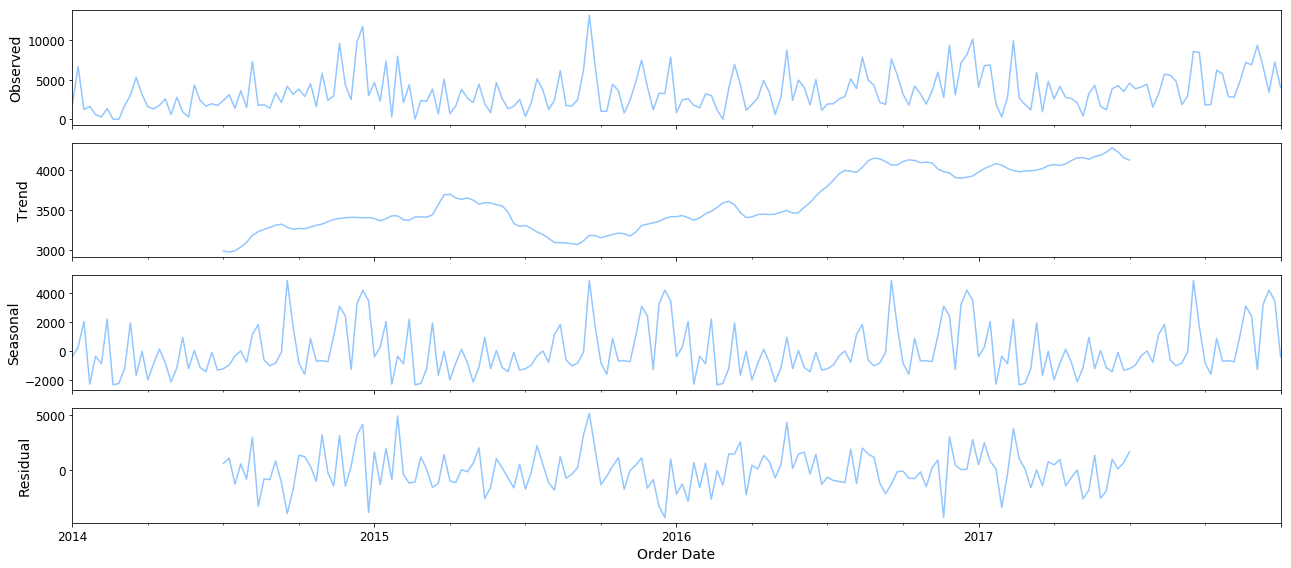

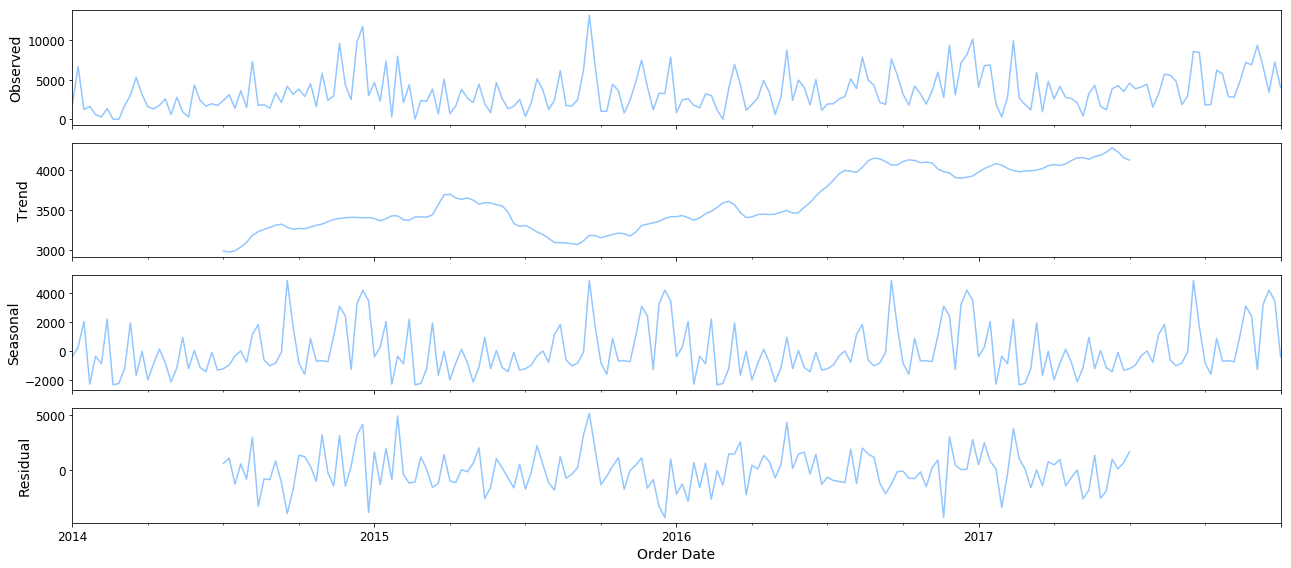

In [9]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
result = sm.tsa.seasonal_decompose(furniture_sales_weekly,model='addition')
result.plot()
result.plot().savefig('images/seasonal_decompose.png')

In [38]:
# Training size
set_ratio = 0.8
train_size = int(len(furniture_sales_weekly) * set_ratio)

In [26]:
from sklearn.metrics import mean_squared_error
from pylab import rcParams
import math

def output_results(y_pred, full_dataset, title = 'Output Results', conf_int = []):
    
    y_values = y_pred # .predicted_mean
    
    fig = plt.figure()
    
    train_len = len(full_dataset) - len(y_values)
    
    rcParams['figure.figsize'] = 18,12
    
    rmse = math.sqrt(mean_squared_error(full_dataset[train_len:], y_values))
    title = title + ' - RMSE: {}'.format(str(round(rmse, 2)))    
    
    plt.xlabel('Date - Week Commencing')
    plt.ylabel('Sales')
    plt.plot(full_dataset[train_len:].index, y_values, label ='One Step Forecast', color = 'red')
    plt.plot(full_dataset[:train_len].index, full_dataset[:train_len], label = 'Training', color = 'blue')
    plt.plot(full_dataset[train_len:].index, full_dataset[train_len:], label = 'Observed', color = 'grey')
    plt.legend()
    
    if len(conf_int):
        plt.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1], color='k', alpha=.2)
        
    
    fig.suptitle(title, fontsize=16)
    
    return plt, rmse

# Moving Average

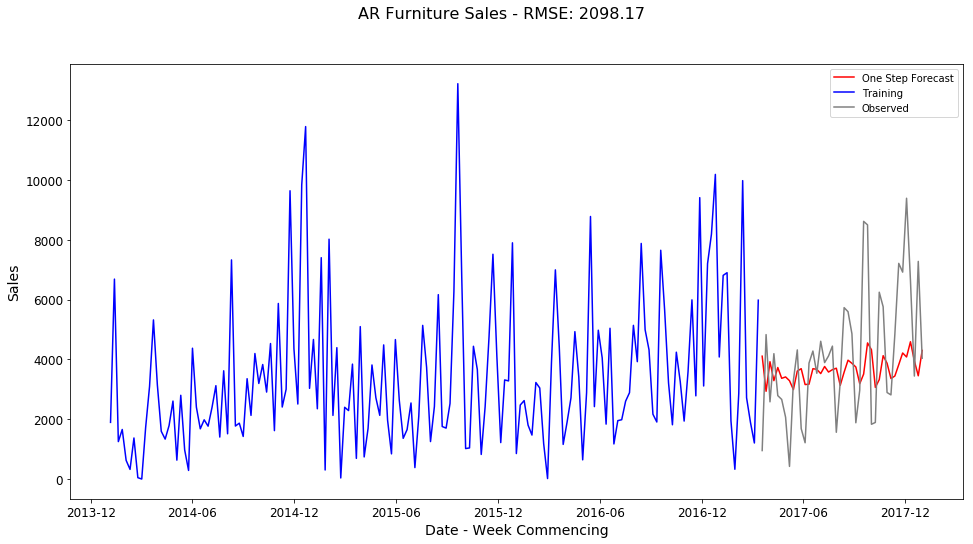

In [27]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(furniture_sales_weekly['Sales'], order = (0,1))
model_fit = model.fit(disp=False)
y_pred = model_fit.predict(start = '2017-03-19')

plt, rmse = output_results(y_pred,furniture_sales_weekly['Sales'], 'AR Furniture Sales' )
plt.savefig('images/ARMAResult.png')

# ARIMA

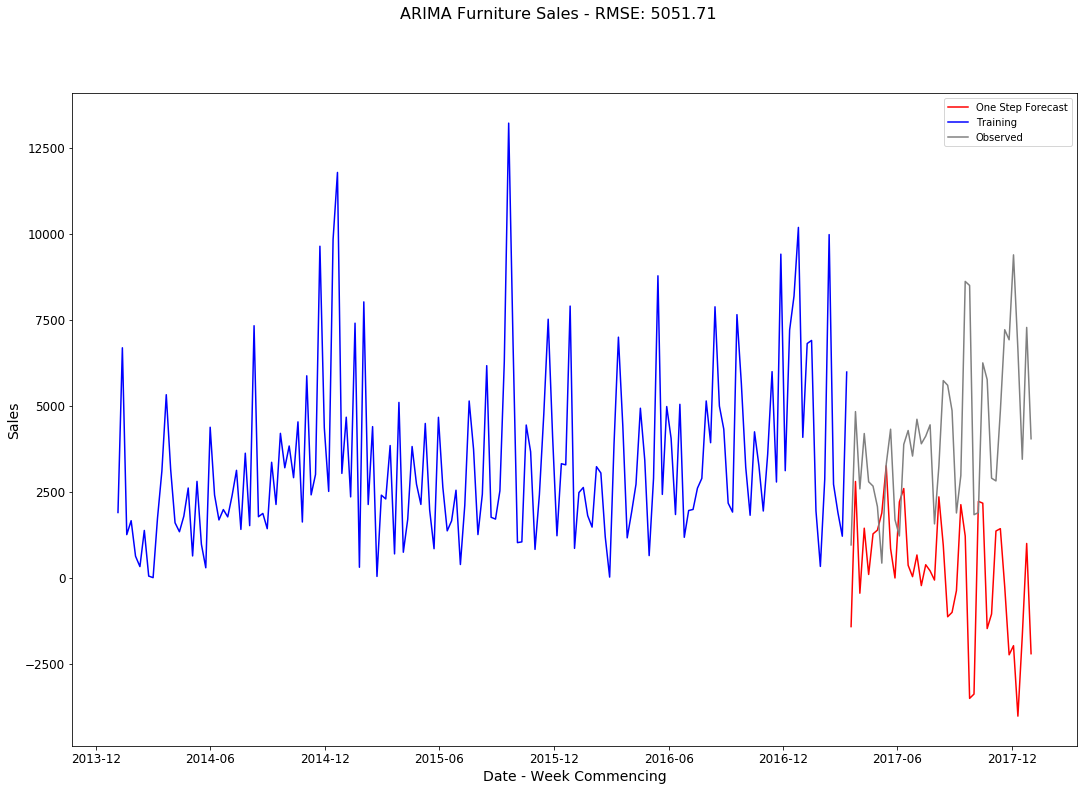

In [28]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(furniture_sales_weekly['Sales'], order = (1,1,1))
model_fit = model.fit(disp=False)
y_pred = model_fit.predict(start = '2017-03-19')

plt, rmse = output_results(y_pred,furniture_sales_weekly['Sales'], 'ARIMA Furniture Sales' )
plt.savefig('images/ARIMAResult.png')

In [125]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  208
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1910.128
Method:                       css-mle   S.D. of innovations           2326.888
Date:                Fri, 07 Jun 2019   AIC                           3828.255
Time:                        12:09:36   BIC                           3841.605
Sample:                    01-12-2014   HQIC                          3833.653
                         - 12-31-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.4946      3.160      3.321      0.001       4.301      16.688
ar.L1.D.Sales     0.1581      0.069      2.305      0.022       0.024       0.293
ma.L1.D.Sales    -1.0000      0.015    -66.748      0.000      -1.029      -0.971
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.3258           +0.0000j            6.3258            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

## Seasonal 

In [32]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 0, 0, 52)


In [37]:
lowest_aic = 999999999
strlowest = ''

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture_sales_weekly['Sales'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            if lowest_aic >  results.aic:
                strlowest = 'SARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print (strlowest)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

SARIMA(1, 1, 1)x(1, 1, 0, 52)52 - AIC:1889.7557324050163


In [39]:
mod = sm.tsa.statespace.SARIMAX(furniture_sales_weekly['Sales'],
                                order=(0,1,1),
                                seasonal_order=(1,1,0,52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()


print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9843      0.172     -5.736      0.000      -1.321      -0.648
ar.S.L52      -0.4989      0.142     -3.517      0.000      -0.777      -0.221
sigma2      9.498e+06   2.03e+06      4.677      0.000    5.52e+06    1.35e+07


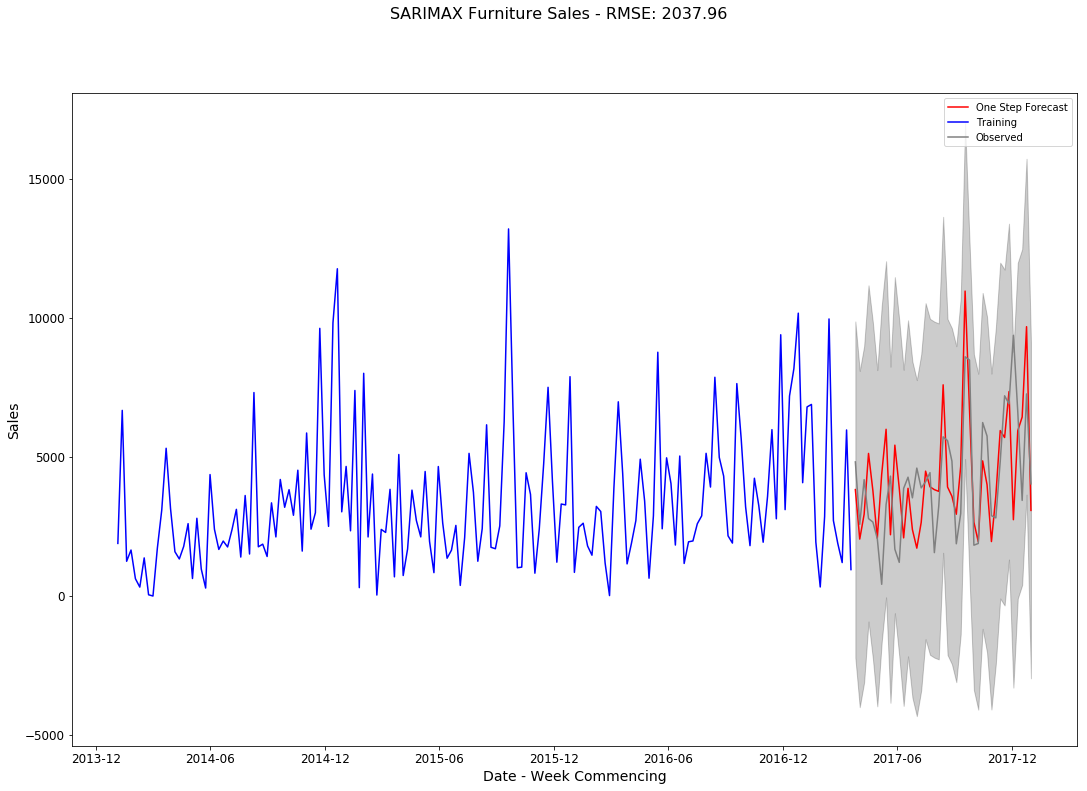

In [41]:
y_pred = results.get_prediction(start = '2017-03-26')


plt, rmse = output_results(y_pred.predicted_mean,furniture_sales_weekly['Sales'], 'SARIMAX Furniture Sales',y_pred.conf_int())

plt.savefig('images/SARIMAX.png')

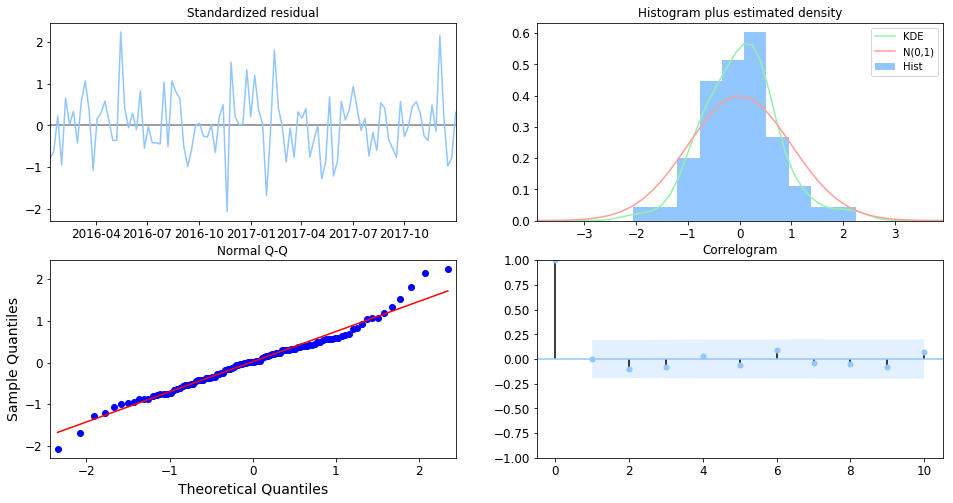

In [43]:
results.plot_diagnostics(figsize=(16,8))
plt.savefig('images/SARIMAdiagnostics')
plt.show()